### Import python packages

In [57]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from yahooquery import Ticker

import torch
import torch.utils.data
from torch import optim
from torch import nn
from torch.autograd import Variable

In [58]:
from ibov.utils import load_config
from ibov.feature import create_lags
from ibov.model import IbovModel, train

### Load Data

In [59]:
config = load_config()

In [60]:
data_root_dir = config["data"]["root"]

In [61]:
ibov = Ticker(symbols = config["ibovespa"]["ticker"])
ibov_data = ibov.history(period="max")
ibov_data.to_csv(f"{data_root_dir}/ibovespa.csv")

### Geração dos conjuntos de dados de treino

In [62]:
dados_ibov = pd.read_csv(f"{data_root_dir}/ibovespa.csv")

In [63]:
dados_ibov_train = dados_ibov.sort_values(by="date", ascending=False)[180:360].reset_index(drop="True")
dados_ibov_train.head()

,symbol,date,low,close,volume,open,high,adjclose
0,^BVSP,2020-04-16,77452.0,77812.0,9028400.0,78837.0,80167.0,77812.0
1,^BVSP,2020-04-15,77546.0,78831.0,9758400.0,79911.0,80035.0,78831.0
2,^BVSP,2020-04-14,78848.0,79918.0,8593600.0,78848.0,81668.0,79918.0
3,^BVSP,2020-04-13,76405.0,78836.0,7651300.0,77682.0,78836.0,78836.0
4,^BVSP,2020-04-09,77457.0,77682.0,10748700.0,78640.0,80428.0,77682.0


In [64]:
dados_ibov_valid = dados_ibov.sort_values(by="date", ascending=False)[0:180].reset_index(drop="True")
dados_ibov_valid.head()

,symbol,date,low,close,volume,open,high,adjclose
0,^BVSP,2021-01-08,122386.0,125199.0,11085800.0,122387.0,125324.0,125199.0
1,^BVSP,2021-01-07,119101.0,121956.0,11774800.0,119103.0,121983.0,121956.0
2,^BVSP,2021-01-06,118917.0,119851.0,11638200.0,119377.0,120924.0,119851.0
3,^BVSP,2021-01-05,116756.0,119223.0,9257100.0,118835.0,119790.0,119223.0
4,^BVSP,2021-01-04,118062.0,118558.0,8741400.0,119024.0,120354.0,118558.0


In [74]:
window = 7#config["feature"]["window"]

In [75]:
window

7

In [76]:
trainY, trainX = create_lags(data = dados_ibov_train["close"], window = window)
validY, validX = create_lags(data = dados_ibov_valid["close"], window = window)

### Definição do modelo

#### Test Net

random_data = torch.rand((1, 1, 7))
test_net = Net(window=window)
result = test_net(random_data)
print(result)

### Train Net

In [77]:
torch.manual_seed(0)

In [78]:
tensor_x = torch.Tensor(np.array(trainX))
tensor_y = torch.Tensor(np.array(trainY))

In [13]:
tensor_val_x = torch.Tensor(np.array(validX))
tensor_val_y = torch.Tensor(np.array(validY))

In [14]:
dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [15]:
val_dataset = torch.utils.data.TensorDataset(tensor_val_x,tensor_val_y)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=10)

In [16]:
model = IbovModel(window=window)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

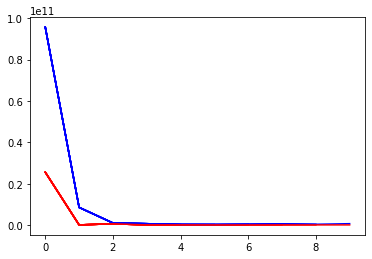

In [17]:
train(dataloader, val_dataloader, model, criterion, optimizer, epochs=10)

In [18]:
import seaborn as sns

In [19]:
prediction = np.hstack(model(tensor_x).detach().numpy()).tolist()
true_value = np.hstack(trainY).tolist()
evaluation_data = pd.DataFrame(columns=["pred", "true"])
evaluation_data["pred"] = prediction
evaluation_data["true"] = true_value
evaluation_data.head()

,pred,true
0,75069.867188,78625.0
1,71456.781250,76358.0
2,71192.031250,74073.0
3,71550.601562,69538.0
4,72231.890625,72253.0


In [20]:
prediction = np.hstack(model(tensor_val_x).detach().numpy()).tolist()
true_value = np.hstack(validY).tolist()
evaluation = pd.DataFrame(columns=["pred", "true"])
evaluation["pred"] = prediction
evaluation["true"] = true_value
evaluation.head()

,pred,true
0,119317.031250,119306.0
1,118438.812500,119475.0
2,117058.203125,119051.0
3,116241.851562,117857.0
4,117085.617188,116348.0


In [22]:
from sklearn.metrics import median_absolute_error, accuracy_score, confusion_matrix

In [23]:
median_absolute_error(evaluation.true, evaluation.pred)

1173.91015625

In [24]:
np.mean(np.abs(evaluation.true - evaluation.pred))

1322.4317064606741

evaluation = evaluation.append(evaluation_data)

In [ ]:
true = evaluation.true[:-1].reset_index(drop=True)
pred = evaluation.true[1:].reset_index(drop=True)

In [ ]:
a = pd.DataFrame(columns=["pred", "true"])
a["pred"] = pred
a["true"] = true

In [ ]:
pred

In [ ]:
delta_pred = [1 if np.sign(pred[idx]-pred[idx+1]) >=0 else 0 for idx in range(pred.shape[0]-1)]
delta_true = [1 if np.sign(true[idx]-true[idx+1]) >=0 else 0 for idx in range(true.shape[0]-1)]

In [ ]:
confusion_matrix(delta_true, delta_pred)

In [ ]:
confusion_matrix(delta_true, delta_pred)

In [ ]:
median_absolute_error(a.true, a.pred)

In [ ]:
from matplotlib import pyplot

In [ ]:
a4_dims = (16.5, 11.7)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, data=a, dashes=False, markers=True)

### Sagemaker Training

In [50]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session(boto_session=boto3.session.Session(region_name="sa-east-1"))

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/ibovespa'

try:
    role = sagemaker.get_execution_role()
except Exception as err:
    role = "arn:aws:iam::977053370764:role/service-role/AmazonSageMaker-ExecutionRole-20201202T141643"

Couldn't call 'get_role' to get Role ARN from role name aadelmo to get Role path.


In [51]:
data_root_dir

'data'

In [52]:
input_data = sagemaker_session.upload_data(path=data_root_dir, bucket=bucket, key_prefix=prefix)
input_data

's3://sagemaker-sa-east-1-977053370764/sagemaker/ibovespa'

In [53]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="ibov",
                    py_version="py3",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.m5.large')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [54]:
estimator.fit({'train': input_data})

2021-01-09 21:24:39 Starting - Starting the training job...
2021-01-09 21:24:42 Starting - Launching requested ML instancesProfilerReport-1610227477: InProgress
......
2021-01-09 21:25:56 Starting - Preparing the instances for training...
2021-01-09 21:26:40 Downloading - Downloading input data...
2021-01-09 21:27:15 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-01-09 21:27:14,616 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-01-09 21:27:14,619 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-09 21:27:14,631 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-01-09 21:27:20,953 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-01-09 21:27:21,192 sagemaker-containers INFO     Module train does not pr


2021-01-09 21:27:37 Uploading - Uploading generated training model
2021-01-09 21:27:37 Completed - Training job completed
Training seconds: 57
Billable seconds: 57


In [55]:
predictor = estimator.deploy(initial_instance_count=1,instance_type="ml.m4.xlarge")

-------------!

In [72]:
tensor_x

tensor([[ 78831.,  79918.],
        [ 79918.,  78836.],
        [ 78836.,  77682.],
        [ 77682.,  78625.],
        [ 78625.,  76358.],
        [ 76358.,  74073.],
        [ 74073.,  69538.],
        [ 69538.,  72253.],
        [ 72253.,  70967.],
        [ 70967.,  73020.],
        [ 73020.,  74640.],
        [ 74640.,  73429.],
        [ 73429.,  77710.],
        [ 77710.,  74956.],
        [ 74956.,  69729.],
        [ 69729.,  63570.],
        [ 63570.,  67069.],
        [ 67069.,  68332.],
        [ 68332.,  66895.],
        [ 66895.,  74617.],
        [ 74617.,  71168.],
        [ 71168.,  82678.],
        [ 82678.,  72583.],
        [ 72583.,  85171.],
        [ 85171.,  92214.],
        [ 92214.,  86067.],
        [ 86067.,  97997.],
        [ 97997., 102233.],
        [102233., 107224.],
        [107224., 105537.],
        [105537., 106625.],
        [106625., 104172.],
        [104172., 102984.],
        [102984., 113681.],
        [113681., 114586.],
        [114586., 11

In [79]:
predictor.predict(tensor_x)

array([[ 79343.164],
       [ 78710.42 ],
       [ 76628.586],
       [ 77102.51 ],
       [ 75351.94 ],
       [ 75013.85 ],
       [ 72804.68 ],
       [ 73051.31 ],
       [ 74357.984],
       [ 73845.84 ],
       [ 74324.69 ],
       [ 72346.18 ],
       [ 73916.8  ],
       [ 72973.9  ],
       [ 70750.48 ],
       [ 69166.48 ],
       [ 68273.21 ],
       [ 73456.43 ],
       [ 70121.07 ],
       [ 78198.74 ],
       [ 78006.12 ],
       [ 82739.89 ],
       [ 85249.53 ],
       [ 87938.67 ],
       [ 96595.914],
       [ 95749.57 ],
       [100230.12 ],
       [103482.95 ],
       [106543.23 ],
       [109117.45 ],
       [109106.35 ],
       [110587.93 ],
       [109225.65 ],
       [113639.695],
       [115790.1  ],
       [117169.9  ],
       [117003.164],
       [116648.19 ],
       [115874.63 ],
       [116319.945],
       [116879.88 ],
       [116978.5  ],
       [115663.51 ],
       [115438.02 ],
       [116012.04 ],
       [116933.98 ],
       [116748.31 ],
       [11681